# 11 - Clasificación de textos con NLTK y Scikit-Learn

* NLTK dispone de un wrapper para hacer uso de los clasificadores de Scikit-Learn.


* Este wrapper consiste básicamente en pasarle una ***bolsa de palabras*** (en formato NLTK) y un ***objeto de alguna clase de Scikit que implemente un clasificador*** (Naive Bayes, Regresión Logística, SVM, etc.)


* En este notebook (al igual que en el notebbok "09_Sckit_Clasificacion_textos.ipynb") vamos a ver como clasificar una serie de Tweets en Ingles sobre críticas a los productos de Apple.


* Estos tweets estan clasificados como: *positivos*, *neutros* o *negativos*


* El este notebook vamos a realizar los sigueintes pasos (similar que en el notebook "09_Sckit_Clasificacion_textos.ipynb" pero usando diferentes librerías).
    
    1. Carga de los datos (tweets)
    2. Normalización (en ingles) de los tweets con Spacy
    3. Particionado de Datos con Scikit
    4. Creacción de la Bolsa de Palabras con NLTK
    5. Creacción de modelos con NLTK y Scikit
        - Multinomial Naive Bayes
        - Bernoulli Naive Bayes
        - Regresion Logistica
        - Support Vector Machine
    6. Evaluación de los modelos

<hr>


## 1. Carga de Datos


* El primer paso que vamos a realizar es el de cargar los datos. Para ello ***leeremos el csv con pandas*** (pasandolo a un dataframe) y posteriormente lo transformaremos en una lista de tuplas (*tweets*) donde cada tupla esta formada por:
    - **Posición 0**: Tweet
    - **Posición 1**: Polaridad (Positivo | Neutro | Negativo)

In [1]:
import pandas as pd
tweets_file = './data/Apple_Tweets.csv'
df = pd.read_csv(tweets_file, header=None)
tweets = [tuple(x) for x in df.values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 3804


<hr>


## 2. Normalización

* Para la normalización en este ejemplo haremos uso de ***spaCy***, de la misma mamera que se ha realizado en el notebook "09_Sckit_Clasificacion_textos.ipynb".


* Para ***normalizar*** los tweets realizaremos las siguientes acciones:
    1. Pasamos las frases a minúsculas.
    2. Eliminamos los signos de puntuación.
    3. Eliminamos las palabras con menos de 3 caracteres.
    4. Eliminamos las Stop-Words.
    5. Eliminamos las palabras que empiecen por '@' o 'http'.
    6. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: *De cara a la normalización de textos se pueden realizar más acciones que las que vamos a realizar, pero con estas serán más que suficientes para realizar un ejercicio con fines didácticos*
    

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

def normalize(tweets):
    """normalizamos los tweets que nos vienen en una lista de tuplas, en la posición '0' de la tupla"""
    for index, tweet in enumerate(tweets):
        tokens = nlp(tweet[0].lower()) # Paso el tweet a minúsculas y a un objeto de la clase Doc de Spacy
        tweet_nor = " ".join([word.lemma_ for word in tokens if (not word.is_punct)
                              and (len(word.text) > 2) and (not word.is_stop) 
                              and (not word.text.startswith('@')) and (not word.text.startswith('http'))])
        tweets[index] = (tweet_nor, tweet[1])
    return tweets

# Normalizamos los tweets
X = normalize(tweets)

<hr>


## 3. Particionado de Datos (Train y Test)

* Vamos a particionar los datos en conjunto de Train y Test.


* Para este ejemplo nos vamos a quedar con:
    - 80% de datos de entrenamiento
    - 20% de datos de test
    
    
* Pasos:
    1. Pasamos el Target (positivo, negativo o neutro) a una lista.
    2. Dividimos los datos en entrenamiento y test


* ***NOTA***: Las estructuras de datos de entrenamiento y test son tuplas de dos posiciones. La primera posición contiene el tweet normalizado y la segunda posición el target. Esta estructura la dejamos de esta manera para construir la estructura de datos que necesita la clase "classify" de NLTK.

In [3]:
from sklearn.model_selection import train_test_split

# Obtenemos el target
y = [y[1] for y in X] 

# Dividimos los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('Número de Tweets para el entrenamiento: {num}'.format(num=len(X_train)))
print('Número de Tweets para el test: {num}'.format(num=len(X_test)))

Número de Tweets para el entrenamiento: 3043
Número de Tweets para el test: 761


<hr>


## 4. Bolsa de Palabras (Extracción de Características)


* NLTK necesita una determina estructura de datos de entrada para generar el modelo. Para ello necesitamos crear:

    - Un Diccionario (CUIDADO no es un diccionario python) con todas las palabras del corpus.
    
    - Una tupla que contenga:
        1. Posición 1 (indice '0'): un Booleano por cada palabra del diccionario, para indicar si aparece o no la palabra de la frase. 
        2. Posición 2 (indice '1'): Etiqueta (target) de la frase. 
    

* Para ello creamos las siguientes 2 funciones:
    

In [4]:
import nltk

def get_unique_words(tweets):
    """Función que devuelve una lista con todas las palabras únicas que aparecen en las frases"""
    all_words = []
    for (tweet, sentiment) in tweets:
        all_words.extend(nltk.word_tokenize(tweet))
    return list(set(all_words))

def extract_features(document):
    """Función que crea el conjunto de entrenamiento del clasificador
       1: Toma todos los documentos del corpus
       2: Toma todas las palabras del corpus
       3: Escribre (True|False) si aparece cada palabra del corpus en la frase
    """
    document_words = set(document)
    features = {}
    for word in unique_words:
        features['contains(%s)' % word] = (word in document_words)
    return features

* El siguiente paso es:
    1. Crear el diccionario del corpus con las palabras únicas
    2. Pasar los datos de entrenamiento y test a la estructura que necesita NLTK:
        * Diccionario python con un Booleano por cada palabra del diccionario de palabras del corpus, para indicar si aparece o no la palabra de la frase. 
        2. Etiqueta (target) de la frase. 

In [5]:
# Creamos el diccionario de palabras
unique_words = get_unique_words(X)

# Creamos las estructaras de datos para NLTK:
X_train_nltk = nltk.classify.apply_features(extract_features, X_train)
X_test_nltk = nltk.classify.apply_features(extract_features, X_test)

<hr>


## 5. Creacción del Modelo


* Una vez tenemos creada la bolsa de palabras, podemos usar cualquier algoritmo de aprendizaje para la clasificación.


* Para este ejemplo vamos a usar los siguientes algoritmos:

    - Naive Bayes (NLTK): https://github.com/nltk/nltk/blob/develop/nltk/classify/naivebayes.py
    - Multinomial Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    - Bernoulli Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html
    - Regresion Logistica: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    - Support Vector Machine: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
    

In [6]:
import nltk
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Clasificadores
print('Entrenando Naive Bayes')
nb = nltk.classify.NaiveBayesClassifier.train(X_train_nltk)

print('Entrenando Multinomial Naive Bayes')
mnb = nltk.classify.SklearnClassifier(MultinomialNB()).train(X_train_nltk)

print('Entrenando Bernoulli Naive Bayes')
bnb = nltk.classify.SklearnClassifier(BernoulliNB()).train(X_train_nltk)

print('Entrenando Regresion Logistica')
lr = nltk.classify.SklearnClassifier(LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)).train(X_train_nltk)

print('Entrenando Support Vector Machine')
svm = nltk.classify.SklearnClassifier(LinearSVC()).train(X_train_nltk)

clasificadores = {'Naive Bayes' : nb,
                  'Multinomial Naive Bayes': mnb,
                  'Bernoulli Naive Bayes': bnb,
                  'Regresion Logistica': lr,
                  'Support Vector Machine': svm}

Entrenando Naive Bayes
Entrenando Multinomial Naive Bayes
Entrenando Bernoulli Naive Bayes
Entrenando Regresion Logistica
Entrenando Support Vector Machine


<hr>


## 6. Evaluación del Modelo


* Para cada uno de los modelos vamos a calcular las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **F1**
    3. **Precision**
    4. **Recall**

In [7]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

evaluacion = list()
for k, v in clasificadores.items():
    print ('EVALUANDO MODELO: {model}'.format(model=k))
    
    # Obtengo las predicciones
    y_predictions = [v.classify(tweet[0]) for tweet in X_test_nltk]
    
    model = {}
    model['name'] = k
    model['accuracy'] = accuracy_score(y_true=y_test, y_pred=y_predictions)
    model['f1'] = f1_score(y_true=y_test, y_pred=y_predictions, average='weighted')
    model['precision'] = precision_score(y_true=y_test, y_pred=y_predictions, average='weighted')
    model['recall'] = recall_score(y_true=y_test, y_pred=y_predictions, average='weighted')
    evaluacion.append(model)

# Pasamos los resultados a un DataFrame para visualizarlos mejor
df = pd.DataFrame.from_dict(evaluacion)
df.set_index("name", inplace=True)
df.head()

EVALUANDO MODELO: Naive Bayes
EVALUANDO MODELO: Multinomial Naive Bayes
EVALUANDO MODELO: Bernoulli Naive Bayes
EVALUANDO MODELO: Regresion Logistica
EVALUANDO MODELO: Support Vector Machine


,accuracy,f1,precision,recall
name,,,,
Naive Bayes,0.588699,0.534712,0.517829,0.588699
Multinomial Naive Bayes,0.578187,0.423650,0.334300,0.578187
Bernoulli Naive Bayes,0.586071,0.452436,0.529157,0.586071
Regresion Logistica,0.605782,0.530581,0.536943,0.605782
Support Vector Machine,0.605782,0.530327,0.540914,0.605782


* Veamos la matriz de confusión para el modelo que mejores resultado obtiene que es la "***Regresión Logística***"

In [8]:
from sklearn.metrics import confusion_matrix

# Matriz de confusión para el modelo de Regresión Logística
confusion = confusion_matrix(y_true=y_test, 
                             y_pred=[lr.classify(tweet[0]) for tweet in X_test_nltk],
                             labels=['positive', 'neutral', 'negative'])

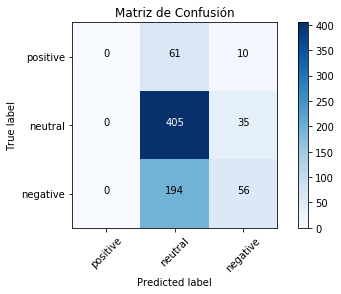

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
plot_confusion_matrix(confusion, classes=['positive', 'neutral', 'negative'], title='Matriz de Confusión')
plt.show()

<hr>


# Conclusiones

* A nivel de Algoritmos de Aprendizaje (Algoritmos de Clasificación) hemos realizado los mismo que en el notebook "09_Sckit_Clasificacion_textos.ipynb" y como se puede apreciar los resultados obtenidos en este notebook son considerablemente peores.


* Esto es debido a como construimos las ***bolsa de palabras***:

    - ***"09_Sckit_Clasificacion_textos.ipynb"***: Seleccionamos solo las 'N' (N=1000) con más frecuencia del corpus y además filtramos aquellas palabras que no aparecen en un mínimo de 'M' (M=3) tweets.
    - ***"11_NLTK_Sckit_Clasificacion_textos.ipynb"*** (este notebook): En este caso construimos la bolsa de palabras sin ningún tipo de restricciones, metiendo todas las palabras en la Bolsa de Palabras.
    
    
* Por otro lado la normalización de datos realizada (tanto en un notebook como en otro) es una ***normalización de datos muy simple y trivial***. No se ha pasado a analizar con un mínimo detalle la naturaleza de los tweets (solo se han eliminado menciones '@' y enlaces 'http') y seguro que hay muchas palabras que distorsionan la clasificación.


* Realizando una normalización muchos más extricta se hubiesen obtenido resultados mejores, pero esto no se ha realizado ya que la finalidad didáctica de estos notebooks ("*09_Sckit_Clasificacion_textos.ipynb*", "*11_NLTK_Sckit_Clasificacion_textos.ipynb*") es ver el proceso de clasificación.